# Demo de Deep Autoencoder (DAE) para procesar datos 
Basado en: 

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

1) Importar librerías:

In [1]:
#@title Librerías a usar
import keras
from keras.layers import Input, Dense
from keras.models import Model
#from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import csv

print("\nLibrerías importadas")


Librerías importadas


2) Configurar los datos cargados (se debe definir de acuerdo a los datos):


In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de IRIS_nombreClases.txt.

Configuración definida de  IRIS.csv
Atributo clase:  Clase :  ['na', 'Setosa', 'Versicolor', 'Virginica']


3) Cargar CSV con datos a procesar y preparar datos para entrenar y probar (ya separados):

In [4]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [6]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (120, 4)
 - y_train (cant):  120
     na [ 0 ]: 0
     Setosa [ 1 ]: 40
     Versicolor [ 2 ]: 40
     Virginica [ 3 ]: 40

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (30, 4)
 - y_test (cant):  30
     na [ 0 ]: 0
     Setosa [ 1 ]: 10
     Versicolor [ 2 ]: 10
     Virginica [ 3 ]: 10


4) Definir la configuración del modelo DAE:

In [7]:
#@title Establecer configuración del modelo

rna_cant_neuronas_capas_ocultas = '12, 8, 4' #@param {type:"string"}
rna_cant_neuronas_capa_features = 2 #@param {type:"integer"}
rna_cant_epocas_entrenamiento =  500#@param {type:"integer"}


# define tamaño de datos de entrada y salida
num_inputs = len(x_train[0])
num_outputs = num_inputs

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
if rna_cant_neuronas_capa_features < 1:
  num_features = 1
else:
  num_features = rna_cant_neuronas_capa_features

# cantidad de neuronas ocultas para la parte Encoder 
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  dae_layers.append( int(val) )

#  agrega la capa de features a las capas
dae_layers.append( num_features ) 

# cantidad de neuronas ocultas para la parte Decoder 
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

# cantidad de épocas del entrenamiento
# (a medida que la cantidad de capas ocultas se mayor y el nro de features es menor, 
#   se recomienda entrenar más épocas)
if rna_cant_epocas_entrenamiento < 50:
  cantEpocas = 50
else:
  cantEpocas = rna_cant_epocas_entrenamiento

print("Configuración del DAE definida: [", num_inputs, dae_layers, num_outputs, "] ")

Configuración del DAE definida: [ 4 [12, 8, 4, 2, 4, 8, 12] 4 ] 


5) Creación del modelo DAE:

In [8]:
#@title Establecer el modelo
# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1 
for num_hid in dae_layers:  

    # define el nombre de la capa oculta
    if num_features==num_hid:
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas
    #eachLay = Dense(num_hid, activation='relu', name=auxlayerName)(eachLay) # capas ocultas
    
    if num_features==num_hid:
      features_Lay = eachLay

output_data_Lay = Dense(num_outputs, activation=None, name='output_data')(eachLay) # capa de salida
##output_data_Lay = Dense(num_outputs, activation='sigmoid', name='output_data')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_data_Lay, output_data_Lay, name='DAE')
DAEmodel.compile(optimizer='adam', loss='mse')
##DAEmodel.compile(optimizer='adam', loss='binary_crossentropy')

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
#plot_model(DAEmodel, show_layer_names=True, show_shapes=True)

Modelo DAE creado con  9  capas:
Model: "DAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
enc_1 (Dense)                (None, 12)                60        
_________________________________________________________________
enc_2 (Dense)                (None, 8)                 104       
_________________________________________________________________
enc_3 (Dense)                (None, 4)                 36        
_________________________________________________________________
features (Dense)             (None, 2)                 10        
_________________________________________________________________
dec_3 (Dense)                (None, 4)                 12        
_________________________________________________________________
dec_2 (Dense)                (

5) Entrenar el modelo DAE:

In [9]:
#@title Entrenar

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
x_train_prep  = np.array(x_train).reshape(len(x_train), num_inputs)
history = DAEmodel.fit(x_train_prep, x_train_prep,
                epochs = cantEpocas, 
                shuffle=True)


Epoch 1/500
4/4 [==============================] - 11s 4ms/step - loss: 36.9018
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 26.0030
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 18.5704
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 14.3567
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 12.0517
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 11.0985
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 10.5605
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 10.0604
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 9.7800
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 9.2414
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7942
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 8.1974
Epoch 13/500
4/4 [==============================] - 

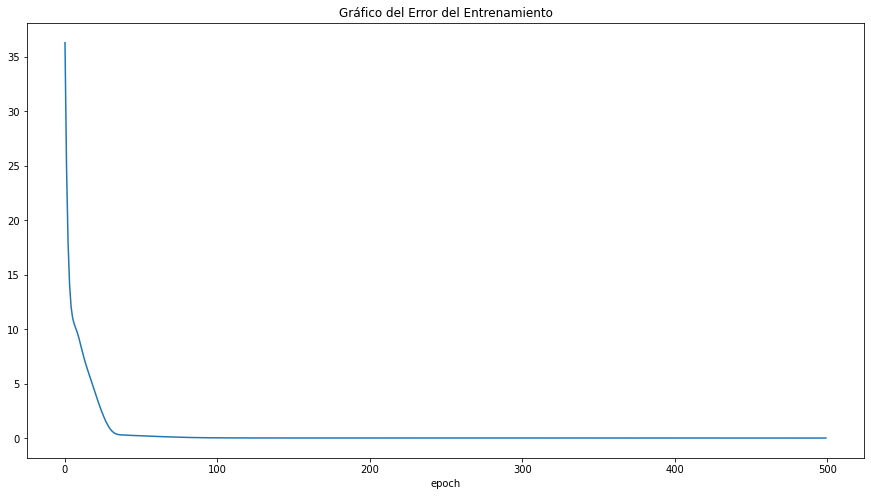

In [10]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()


7) Evaluar el modelo DAE entrenado solicitando que reconstruya los datos de entrenamiento:

In [11]:
#@title Evaluar el modelo con datos de entrenamiento
resEval = DAEmodel.evaluate(x_train_prep, x_train_prep)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval)#[0])
#print("    - Exactitud: ", resEval[1]*100)
print("\n")

# procesa las imágenes con el modelo 
reconstr_data = DAEmodel.predict(x_train_prep)

# muestra las 15 primeras imágenes 
print(">Ejemplos de Resultados: ")
for i in range(len(x_train))[:5]:
      
    # muestra la real
    print("  + Original: ", x_train_prep[i])
    # muestra la generada por el modelo
    #print("  * Reconstr: ", reconstr_data[i])

    # muestra la generada por el modelo con nros redondeados
    format_reconstr = []
    for v in reconstr_data[i]:
      format_reconstr.append( round(v,0) )
    print("  * Reconstr. formateado: ", format_reconstr)

    print("  - Dif:      ", format_reconstr-x_train[i])
    print("\n")  

print("> Total de Diferencias ", sum(reconstr_data-x_train))
print("> Promedio de Diferencias ", sum(reconstr_data-x_train)/len(x_train))

4/4 [==============================] - 0s 3ms/step - loss: 0.0283

>Evaluación del Modelo: 
    - Error:  0.02827303297817707


>Ejemplos de Resultados: 
  + Original:  [6.7 3.1 5.6 2.4]
  * Reconstr. formateado:  [7.0, 3.0, 6.0, 2.0]
  - Dif:       [ 0.3 -0.1  0.4 -0.4]


  + Original:  [5.  3.2 1.2 0.2]
  * Reconstr. formateado:  [5.0, 3.0, 1.0, 0.0]
  - Dif:       [ 0.  -0.2 -0.2 -0.2]


  + Original:  [6.5 3.2 5.1 2. ]
  * Reconstr. formateado:  [7.0, 3.0, 5.0, 2.0]
  - Dif:       [ 0.5 -0.2 -0.1  0. ]


  + Original:  [5.  2.3 3.3 1. ]
  * Reconstr. formateado:  [5.0, 3.0, 3.0, 1.0]
  - Dif:       [ 0.   0.7 -0.3  0. ]


  + Original:  [6.1 2.8 4.7 1.2]
  * Reconstr. formateado:  [6.0, 3.0, 5.0, 2.0]
  - Dif:       [-0.1  0.2  0.3  0.8]


> Total de Diferencias  [ 0.93065548 -0.06345167 -0.07092556 -1.31362948]
> Promedio de Diferencias  [ 0.00775546 -0.00052876 -0.00059105 -0.01094691]


9) Probar el modelo DAE entrenado con los datos de test:

In [12]:
#@title probar el Modelo con datos de prueba
x_test_prep  = np.array(x_test).reshape(len(x_test), num_inputs)

# evalua al modelo 
resEval_test = DAEmodel.evaluate(x_test_prep, x_test_prep)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval_test)#[0])
#print("    - Exactitud: ", resEval_test[1]*100)
print("\n")

# procesa las imágenes con el modelo 
reconstr_data_test = DAEmodel.predict(x_test_prep)

# muestra las 15 primeras imágenes 
print(">Ejemplos de Resultados: ")
for i in range(len(x_test))[:5]:
      
    # muestra la real
    print("  + Original: ", x_test_prep[i])
    # muestra la generada por el modelo
    #print("  * Reconstr: ", reconstr_data_test[i])

    # muestra la generada por el modelo con nros redondeados
    format_reconstr = []
    for v in reconstr_data_test[i]:
      format_reconstr.append( round(v,0) )
    print("  * Reconstr. formateado: ", format_reconstr)

    print("  - Dif:      ", format_reconstr-x_test[i])
    print("\n")  

print("> Total de Diferencias ", sum(reconstr_data_test-x_test))
print("> Promedio de Diferencias ", sum(reconstr_data_test-x_test)/len(x_test))

1/1 [==============================] - 0s 15ms/step - loss: 0.0271

>Evaluación del Modelo: 
    - Error:  0.027063174173235893


>Ejemplos de Resultados: 
  + Original:  [6.7 3.1 4.4 1.4]
  * Reconstr. formateado:  [7.0, 3.0, 4.0, 1.0]
  - Dif:       [ 0.3 -0.1 -0.4 -0.4]


  + Original:  [6.3 3.3 4.7 1.6]
  * Reconstr. formateado:  [6.0, 3.0, 5.0, 2.0]
  - Dif:       [-0.3 -0.3  0.3  0.4]


  + Original:  [6.3 2.9 5.6 1.8]
  * Reconstr. formateado:  [6.0, 3.0, 6.0, 2.0]
  - Dif:       [-0.3  0.1  0.4  0.2]


  + Original:  [4.5 2.3 1.3 0.3]
  * Reconstr. formateado:  [4.0, 3.0, 1.0, 0.0]
  - Dif:       [-0.5  0.7 -0.3 -0.3]


  + Original:  [4.9 2.5 4.5 1.7]
  * Reconstr. formateado:  [5.0, 2.0, 4.0, 2.0]
  - Dif:       [ 0.1 -0.5 -0.5  0.3]


> Total de Diferencias  [ 1.52639341 -1.23861976 -0.28951826 -1.57775136]
> Promedio de Diferencias  [ 0.05087978 -0.04128733 -0.00965061 -0.05259171]


8) A partir del modelo DAE entrenado, generar dos sub-modelos Encoder y Decoder:


*   Generar y usar el modelo Encoder para 'clusterizar' los datos de entrenamiento:


In [13]:
#@title Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_data_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_data_Lay, features_Lay, name='Encoder/Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
#plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)

> Modelo Encoder: 
Model: "Encoder/Clustering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
enc_1 (Dense)                (None, 12)                60        
_________________________________________________________________
enc_2 (Dense)                (None, 8)                 104       
_________________________________________________________________
enc_3 (Dense)                (None, 4)                 36        
_________________________________________________________________
features (Dense)             (None, 2)                 10        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


In [14]:
 #@title Generar Clustering
  # Muestra estadísticas y gráfico de los datos codificados

# determina datos a usar
usarDatos = 'Datos de Prueba' #@param ["Datos Entrenamiento", "Datos de Prueba"] {allow-input: false}
if usarDatos == 'Datos Entrenamiento':
  datosUsar_prep = x_train_prep
  datosUsar_y = y_train
else:
  datosUsar_prep = x_test_prep
  datosUsar_y = y_test 

# procesa los datos para recibir el valor codificado de cada una
x_encoded = CLUSTmodel.predict(datosUsar_prep)

# calcula estadisticas
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]: 
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]: 
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Datos Originales codificado en ", num_features," valores: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_encoded))
print("\n\n")

if len(x_encoded)>0 and len(x_encoded[0])>0:
  
  import ipywidgets as widgets
  from ipywidgets import Box, Layout

  colValues = range(len(x_encoded[0]))

  # agrega los combos
  comboColX = widgets.Dropdown(
      options=colValues,
      value=colValues[0],
      description='Columna X:',
      disabled=False,
  )
  if len(colValues)>1:
    valYsel = colValues[1]
  else:
    valYsel = colValues[0]

  comboColY = widgets.Dropdown(
      options=colValues,
      value=valYsel,
      description='Columna Y:',
      disabled=False,
  )


  ui = widgets.HBox([comboColX, comboColY])

  import matplotlib.ticker as ticker
    
  def fmtClases(x, pos):
    return CLASES[int(x)]

  def cambiaSeleccion(x, y):
    # llama a la función 
    # para generar el gráfico con las columnas seleccionadas
    # muestra el gráfico codificado 
    plt.figure(figsize=(15, 8))
    plt.scatter(x_encoded[:,x], x_encoded[:,y], c=datosUsar_y, cmap='jet')
    plt.colorbar(format=ticker.FuncFormatter(fmtClases))    
    plt.grid(color='grey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='grey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.title("Representación de Datos Clusterizados", fontsize = 20)
    plt.show()


  out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
  display(ui, out)      



> Estadísticas de Clutering de Datos Originales codificado en  2  valores: 
- Mínimos:    [ 3.61842537 -6.59993505]
- Máximos:    [ 7.09073496 -3.20684981]
- Totales:    [ 158.32064629 -145.9934175 ]
- Promedios:  [ 5.27735488 -4.86644725]





Output()

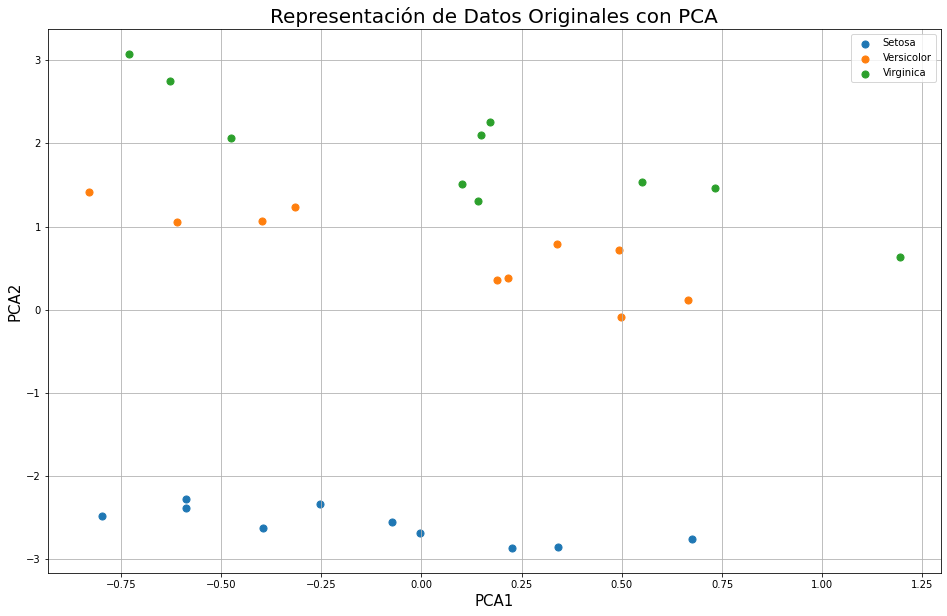

In [15]:
#@title Función auxiliar para generar gráfico PCA de comparación

# función auxiliar para generar un gráfico 
# con los valores codificados 
# usando PCA para simplificarlos en 2 ejes
def genera_grafico_pca(datos, clases, titulo):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(datos)
    principalDf = pd.DataFrame(data = principalComponents,
                columns = ['pca_1', 'pca_2'])
    finalDf = pd.concat([principalDf, 
                        pd.DataFrame(clases, columns = ['target'])], 
                        axis = 1)

    fig = plt.figure(figsize = (16,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA1', fontsize = 15)
    ax.set_ylabel('PCA2', fontsize = 15)
    ax.set_title(titulo, fontsize = 20)
    for target in set(clases):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pca_2'],
                  finalDf.loc[indicesToKeep, 'pca_1'],
                  s = 50)
    ax.legend(CLASES[1:])
    ax.grid()


# muestra el gráfico con originales con PCA (para que tenga 2 dimensiones)
genera_grafico_pca(datosUsar_prep, datosUsar_y, "Representación de Datos Originales con PCA")


*   Generar y usar el modelo Decoder para generar nuevas datos similares a los entrenadas:

In [16]:
#@title Generar el sub-modelo Decoder para Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name  
  
  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estructura
  if auxName.startswith('dec_') or auxName=='output_data':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights()) 
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen) 

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder/Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
#plot_model(GENmodel, show_layer_names=True, show_shapes=True)

> Modelo Decoder: 
Model: "Decoder/Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gen (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dec_3 (Dense)                (None, 4)                 12        
_________________________________________________________________
dec_2 (Dense)                (None, 8)                 40        
_________________________________________________________________
dec_1 (Dense)                (None, 12)                108       
_________________________________________________________________
output_data (Dense)          (None, 4)                 52        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________


In [17]:
#@title Ejecuta el Generator
#  usando valores definidos al azar como datos de entrada
cantGenerar = 5 #@param {type:"integer"}

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros 
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantGenerar, num_features) "-- )
arX = []
minRnd = 1
maxRnd = num_features
for i in range(cantGenerar):
  X = np.zeros(num_features)
  for j in range(np.random.randint(low=minRnd, high=maxRnd)):
      pos = np.random.randint(low=0, high=num_features-1)
      # si están definidas las estadisticas las usa, sino no
      if (minArClust is None or  maxArClust is None):
          X[pos] = np.random.uniform()    
      else:
          X[pos] = np.random.uniform(minArClust[pos], maxArClust[pos])              
      
  arX.append( X )

# ejecuta el modelo Generator
reconstr_data_gen = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados: ")
# muestra las 15 primeras imágenes 
print("\n>Ejemplos de Resultados: ")
for i in range(len(arX)):
      
    # muestra la real
    print("  + Randoms: ", arX[i])
    # muestra la generada por el modelo
    #print("  * Constr.: ", reconstr_data_gen[i])

    # muestra la generada por el modelo con nros redondeados
    format_reconstr_data_gen = []
    for v in reconstr_data_gen[i]:
      format_reconstr_data_gen.append( round(v,0) )
    print("  * Constr. formateado: ", format_reconstr_data_gen)

    print("\n")  




> Resultados: 

>Ejemplos de Resultados: 
  + Randoms:  [5.64488016 0.        ]
  * Constr. formateado:  [6.0, 1.0, 8.0, 3.0]


  + Randoms:  [6.91152653 0.        ]
  * Constr. formateado:  [7.0, 1.0, 10.0, 4.0]


  + Randoms:  [5.19247817 0.        ]
  * Constr. formateado:  [5.0, 1.0, 7.0, 3.0]


  + Randoms:  [5.52323684 0.        ]
  * Constr. formateado:  [5.0, 1.0, 8.0, 3.0]


  + Randoms:  [5.62470908 0.        ]
  * Constr. formateado:  [6.0, 1.0, 8.0, 3.0]


